In [1]:
from LZGraphs import AAPLZGraph

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm
mpl.rcParams['figure.figsize'] = (15,7)
import numpy as np

/home/thomas/Desktop/LZGraphs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The Data Used

The AAPLZGraph works on amino acidsequences and is best suited repertoire analysis and inference,LZPgen prediction and sequence generation on the amino acid level.
The nodes in the graph encode the amino acid LZ sub-pattern together with the position of the sub-pattern in the sequence.
The reuslting graph gurantees it satisfies the DAG constraint.

In our example we will use the V and J calls for the sake of some of the examples.
Keep in mind those are not mandatory and can be left out, the only benifit one can achive by including the V and J calls is the inference of those calls in the some of the inference methods shown below.

first we will load the sequence we will use from out example datasets:

In [2]:
example_sequences = pd.read_csv('ExampleData3.csv',
                               index_col=0)
example_sequences

,cdr3_amino_acid,V,J
12787,CASSGLAGSRSYNEQFF,TRBV2-1*01,TRBJ2-1*01
11502,CASSPTGGVYEQYF,TRBV19-1*01,TRBJ2-7*01
18830,CASSQTGESNQPQHF,TRBV6-5*01,TRBJ1-5*01
16109,CASSKTDISSPLHF,TRBV19-1*01,TRBJ1-6*01
19101,CASSLAGHSGGAQRGNEQFF,TRBV5-1*01,TRBJ2-1*01
...,...,...,...
8408,CASSFTGSSYEQYF,TRBV7-9*01,TRBJ2-7*01
6485,CASGGGGPTDTQYF,TRBV27-1*01,TRBJ2-3*01
23655,CAWRGQGFNEKLFF,TRBV30-1*01,TRBJ1-4*01
2036,CASSLGSGGYSPLHF,TRBV7-6*01,TRBJ1-6*01


# Creating The AAPLZGraph

In order to create an instance of a AAPLZGraph all we need is to provide the class constructor either a list of sequence or a DataFrame matching the column naming convention as in `ExampleData3.csv` 

Below is an example of the graph creation:

In [3]:
my_aap_lzgraph = AAPLZGraph(example_sequences)

We can see from the verbose generated the amount of time it took to create the graph and the different steps taken along the way.

A good sanity check that the graph creation was indeed correct and that we accidentally didnt pass the name of the column by mistake or any other non sequence strings is to check the list of edges in the graph, see example below: 

In [4]:
len(my_aap_lzgraph.edges) 

9528

We can see above that over the 5000 sequences we had in our example file we have discovered 9528 unique edges which means no issues on your side.
One should double check if he get less than 30 edges for any number of sequences larger than 30.

# Using The AAPLZGraph

### 1. Deriving a Featrure Vector

Keep in mind that the feature vector derived for an AAPLZGraph is based on the spesific nodes discoverd when processing the given repertoire and some of fraction of those nodes will be unique for that repertoire, which means those feature will not exist in other repertoires.

One can overcome this by either taking the union of feature vector keys (the feature vector is returned as a dictionary) and using only the intersection of all the features vectors keys.

Another option is to examine the only the unique features from each repetoire.

To derive a feature vector for a single repertoire one should follow the below example

In [5]:
feature_vector = my_aap_lzgraph.eigenvector_centrality()

In [6]:
type(feature_vector)

dict

The eigenvector_centrality method will return the eigenvector centrality value for each node in your AAPLZGraph, the output is a dictionary, to further use this feature vector you would want to extract the values of the output dictionary and convert it to a numpy array:

In [7]:
list(feature_vector)[10:15]

['Q_15', 'F_16', 'F_17', 'SP_5', 'T_6']

In [8]:
feature_vector = np.array(list(feature_vector.values()))

In [9]:
feature_vector

array([5.36044058e-24, 1.48330129e-21, 9.35285107e-20, ...,
       3.82354002e-13, 4.55924711e-20, 2.86957983e-13], shape=(1692,))

### 2. Deriving LZPgen

Below is an example of how one can derive the LZPgen based on the AAPLZGraph.

In [10]:
lzpgens = []
# iterate over each sequence
for sequence in example_sequences['cdr3_amino_acid']:
    # convert sequence to graph sub-patterns
    walk = AAPLZGraph.encode_sequence(sequence)
    # calculate the lzpgen based on the fitted NaiveLZGraph
    lzpgen = my_aap_lzgraph.walk_probability(walk,verbose=False)
    lzpgens.append(lzpgen)

/tmp/ipykernel_583883/2726558134.py:1: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(-np.log10(lzpgens))


Text(0.5, 0, '-log10(AAPLZPgen)')

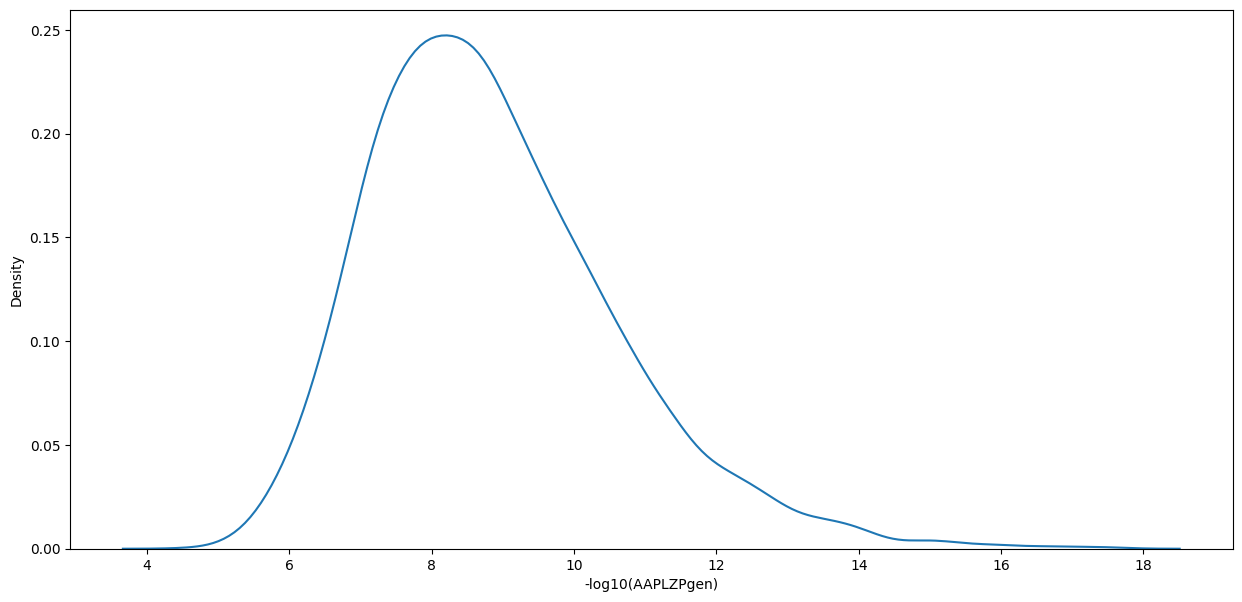

In [11]:
sns.kdeplot(-np.log10(lzpgens))
plt.xlabel('-log10(AAPLZPgen)')

### 3. Generating Sequences

Below is an example of how one can generate new sequences using the AAPLZGraph

In [12]:
my_aap_lzgraph.unsupervised_random_walk()

(['C_1',
  'A_2',
  'S_3',
  'SL_5',
  'E_6',
  'G_7',
  'T_8',
  'SG_10',
  'N_11',
  'SP_13',
  'L_14',
  'F_15'],
 'CASSLEGTSGNSPLF')

The above call to the `unsupervised_random_walk` method will generate a sequence starting in a random initial state and will terminate at a teminal state based on the procedure described in the paper.
The method returns the steps taken (the actual graph nodes) and the resulting sequence.

In [13]:
my_aap_lzgraph.random_walk(initial_state='C_1')

['C_1',
 'A_2',
 'S_3',
 'SL_5',
 'G_6',
 'T_7',
 'GV_9',
 'Y_10',
 'E_11',
 'AF_13',
 'F_14']

One can also use the `random_walk` in order to specify the initial_state of the walk 

In [14]:
my_aap_lzgraph.genomic_random_walk()

(['C_1',
  'A_2',
  'S_3',
  'SL_5',
  'G_6',
  'L_7',
  'G_8',
  'SE_10',
  'T_11',
  'Q_12',
  'YF_14'],
 'TRBV5-1*01',
 'TRBJ2-5*01')

The `genomic_random_walk` method will generate a sequence that has evidenece for the same V and J allele.
The V and J allele will be randomly selected before the sequence is generated based on the marignal probabilites inferend by the graph, one can access them as in the next example:

In [15]:
my_aap_lzgraph.marginal_v_genes

{'TRBV19-1*01': np.float64(0.0774),
 'TRBV7-2*01': np.float64(0.073),
 'TRBV5-1*01': np.float64(0.0688),
 'TRBV7-9*01': np.float64(0.0624),
 'TRBV18-1*01': np.float64(0.0504),
 'TRBV2-1*01': np.float64(0.0492),
 'TRBV6-5*01': np.float64(0.0456),
 'TRBV4-3*01': np.float64(0.043),
 'TRBV9-1*01': np.float64(0.042),
 'TRBV27-1*01': np.float64(0.0366),
 'TRBV4-1*01': np.float64(0.0338),
 'TRBV10-3*01': np.float64(0.0316),
 'TRBV5-4*01': np.float64(0.0298),
 'TRBV30-1*01': np.float64(0.0288),
 'TRBV6-1*01': np.float64(0.0278),
 'TRBV5-6*01': np.float64(0.0258),
 'TRBV29-1*01': np.float64(0.0246),
 'TRBV6-6*01': np.float64(0.0238),
 'TRBV30-1*02': np.float64(0.0228),
 'TRBV7-8*01': np.float64(0.021),
 'TRBV5-5*01': np.float64(0.0182),
 'TRBV11-2*02': np.float64(0.017),
 'TRBV15-1*01': np.float64(0.0138),
 'TRBV14-1*01': np.float64(0.0114),
 'TRBV25-1*01': np.float64(0.0112),
 'TRBV28-1*01': np.float64(0.01),
 'TRBV13-1*01': np.float64(0.0096),
 'TRBV11-3*01': np.float64(0.0094),
 'TRBV7-3*01'

In [16]:
my_aap_lzgraph.marginal_j_genes

{'TRBJ1-2*01': np.float64(0.1568),
 'TRBJ2-7*01': np.float64(0.1448),
 'TRBJ1-1*01': np.float64(0.1404),
 'TRBJ2-3*01': np.float64(0.0962),
 'TRBJ2-1*01': np.float64(0.0916),
 'TRBJ1-5*01': np.float64(0.0772),
 'TRBJ2-5*01': np.float64(0.0678),
 'TRBJ2-2*01': np.float64(0.0574),
 'TRBJ1-6*01': np.float64(0.0512),
 'TRBJ1-4*01': np.float64(0.048),
 'TRBJ1-3*01': np.float64(0.0434),
 'TRBJ2-6*01': np.float64(0.0168),
 'TRBJ2-4*01': np.float64(0.0084)}

### 4. Different Graph Attributes and Repertoire Attributes

Below is an example how one can access the `lengths` attribute of the AAPLZGraph to see what sequence lengths were observed while constucting the graph

In [17]:
my_aap_lzgraph.lengths

{17: 345,
 14: 1161,
 15: 1303,
 20: 28,
 13: 738,
 16: 710,
 19: 94,
 12: 300,
 11: 114,
 18: 178,
 22: 4,
 21: 5,
 10: 17,
 9: 3}

Below is an example of how one can inspect all the uniques initial state observed while constructing the graph

In [18]:
my_aap_lzgraph.initial_state_counts

{'C_1': 4996}

Below is an example of how one can inspect all the unique terminal states observed while constructing the graph

In [19]:
my_aap_lzgraph.terminal_state_counts

{'F_17': 308,
 'YF_14': 92,
 'F_15': 1168,
 'F_14': 997,
 'F_20': 23,
 'F_13': 668,
 'F_16': 641,
 'YF_15': 78,
 'F_19': 79,
 'F_12': 266,
 'F_11': 106,
 'YF_19': 9,
 'YF_13': 39,
 'F_18': 156,
 'TF_20': 1,
 'YF_16': 39,
 'YF_17': 16,
 'FF_17': 3,
 'F_22': 4,
 'TF_13': 24,
 'F_21': 4,
 'TF_17': 16,
 'TF_18': 6,
 'YF_12': 21,
 'TF_15': 43,
 'QYF_14': 1,
 'FF_13': 4,
 'HF_17': 2,
 'TF_14': 61,
 'AFF_16': 1,
 'FF_14': 5,
 'TF_16': 18,
 'F_10': 15,
 'FF_15': 13,
 'FF_16': 8,
 'HF_15': 1,
 'HF_11': 1,
 'TF_12': 12,
 'FF_18': 6,
 'YF_18': 9,
 'TF_11': 1,
 'HF_16': 3,
 'YF_11': 6,
 'HF_14': 4,
 'YF_20': 2,
 'AFF_14': 1,
 'TF_19': 4,
 'HF_20': 2,
 'F_9': 3,
 'HF_13': 2,
 'TF_21': 1,
 'GF_18': 1,
 'SF_13': 1,
 'YF_10': 2,
 'DF_12': 1,
 'FF_19': 1,
 'HF_19': 1}

### 4. Calculating the K1000 Index

Below is an example how one can calculate the K1000 index for a repertoire.

In [20]:
from LZGraphs import k1000_diversity

k1000 = k1000_diversity(list_of_sequences = example_sequences['cdr3_amino_acid'].to_list(),
                    lzgraph_encoding_function= 'aap',
                    draws=50)

print('K1000 Index: ',k1000)

K1000 Index:  939.9


### 5. Plotting Graph Related Features


#### 5.1. Ancestors Descendants Curves Plot
In this chart you can examine at each sub-pattern of a given sequence the amount descendants nodes reachable at each node contained in your sequence, as well as the amount of ancestors at each node. Sequence with different attribute differ both by the slope and the convergence rate of these curve as well as by the intersection point between the curves.

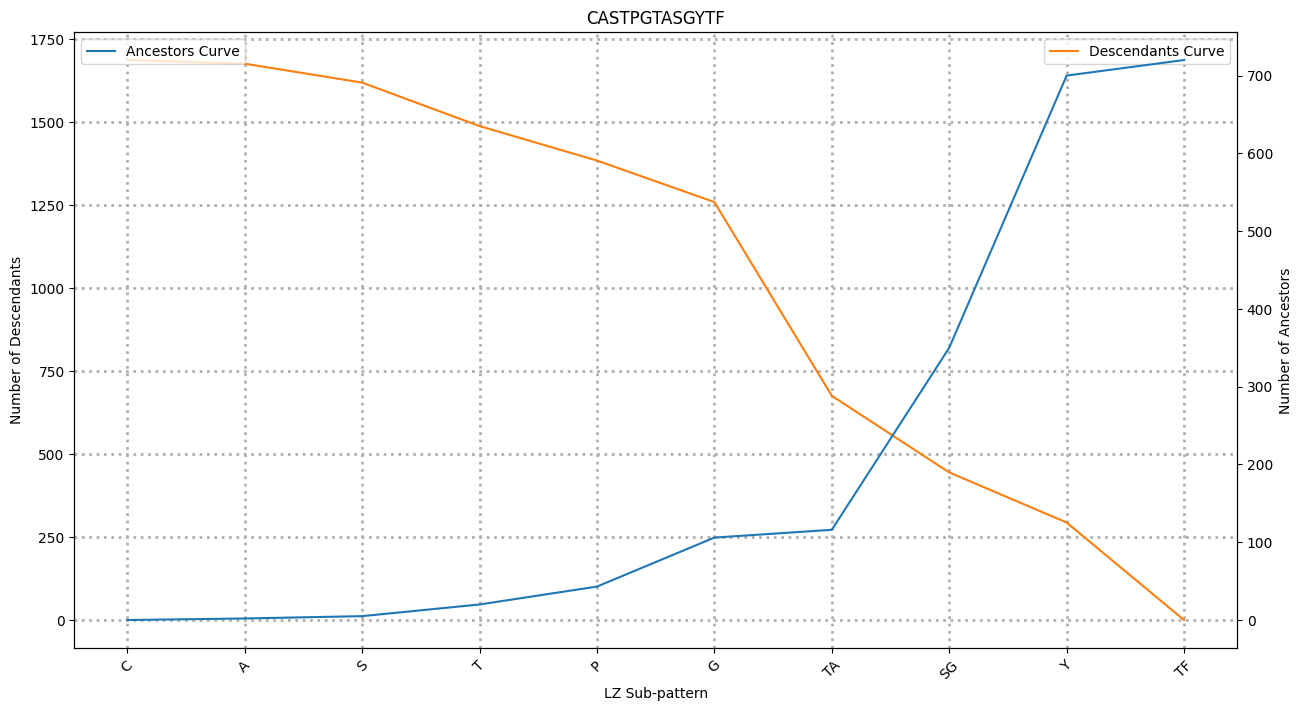

(<Figure size 1500x800 with 2 Axes>,
 (<Axes: title={'center': 'CASTPGTASGYTF'}, xlabel='LZ Sub-pattern', ylabel='Number of Descendants'>,
  <Axes: ylabel='Number of Ancestors'>))

In [21]:
from LZGraphs import plot_ancestor_descendant_curves
sequence = 'CASTPGTASGYTF'
plot_ancestor_descendant_curves(my_aap_lzgraph,sequence)

#### 5.2. Sequence Possible Paths Plot
In this chart we look at a reduced and immediate version of Descendants curve. For each sub-pattern derived from a given sequence and based on an LZGraph, We can examine the number of alternatives there are at each node, this indicates the rarity of a sequence and is correlated with the difference from the mean Levenshtein distance of the repertoire as shown in the LZGraphs paper.

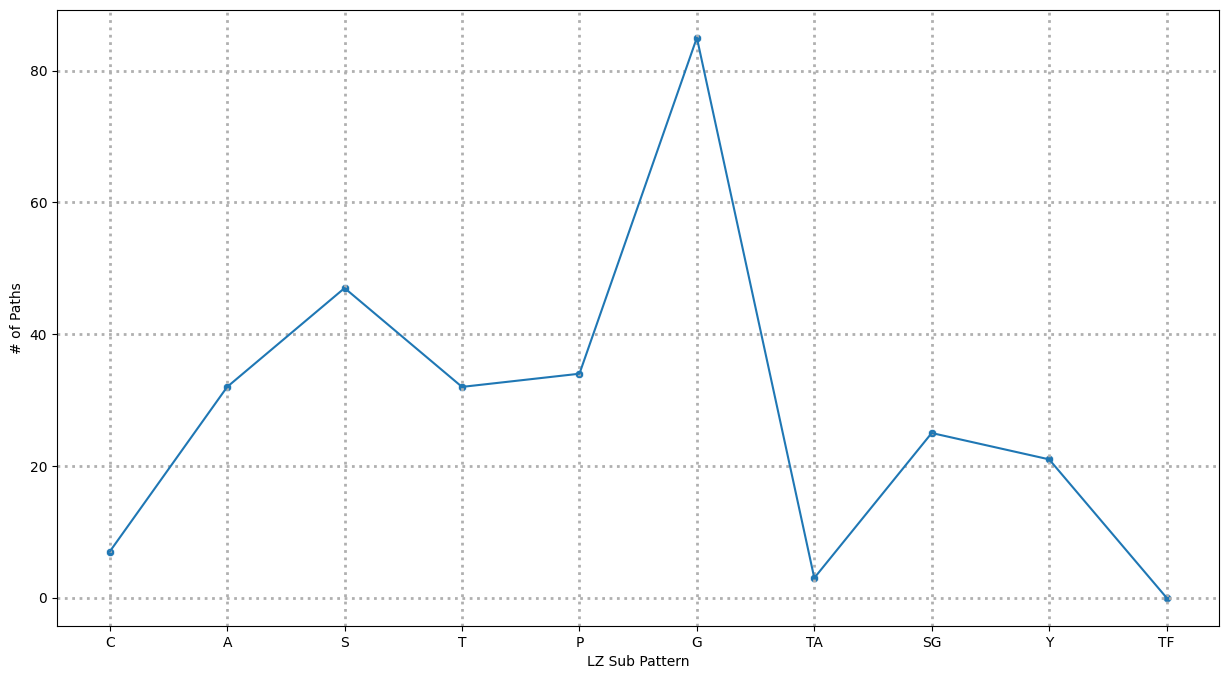

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='LZ Sub Pattern', ylabel='# of Paths'>)

In [22]:
from LZGraphs import plot_possible_paths
sequence = 'CASTPGTASGYTF'
plot_possible_paths(my_aap_lzgraph,sequence)

#### 5.3 Node Genomic Variability Plot
In this chart we look at the number of V and J genes/alleles per node in a given sequence with respect to a given repertoire. Not only can one infer the sub-patterns in a sequence that have the exceptional number of V and J alternatives but also when comparing between the same sequence in different repertoires (different LZGraphs) one can infer the amount difference at each sub-pattern between the two repertoires.

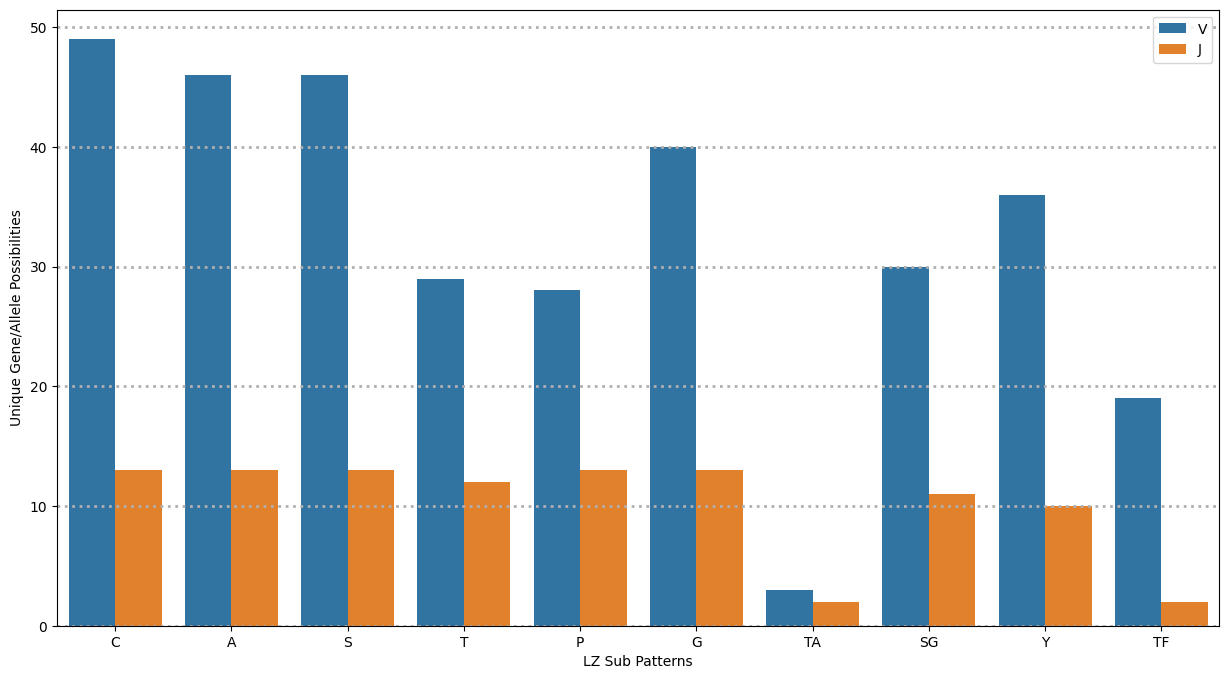

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='LZ Sub Patterns', ylabel='Unique Gene/Allele Possibilities'>)

In [23]:
from LZGraphs import plot_gene_node_variability
sequence = 'CASTPGTASGYTF'
plot_gene_node_variability(my_aap_lzgraph,sequence)

#### 5.4. Edge Genomic Variability Plot
In this chart we look at the number of V and J genes/alleles per edge in a given sequence with respect to a given repertoire.

* Allele/gene names colored in red signify that the allele/gene appeared in all the edges in the given sequence.
* Black cells signify that this spesific allele/gene wasnt observed at that edge.
* The color gradient at each cell represents the probability of choosing that edge under the constraint of having that specific V/J.

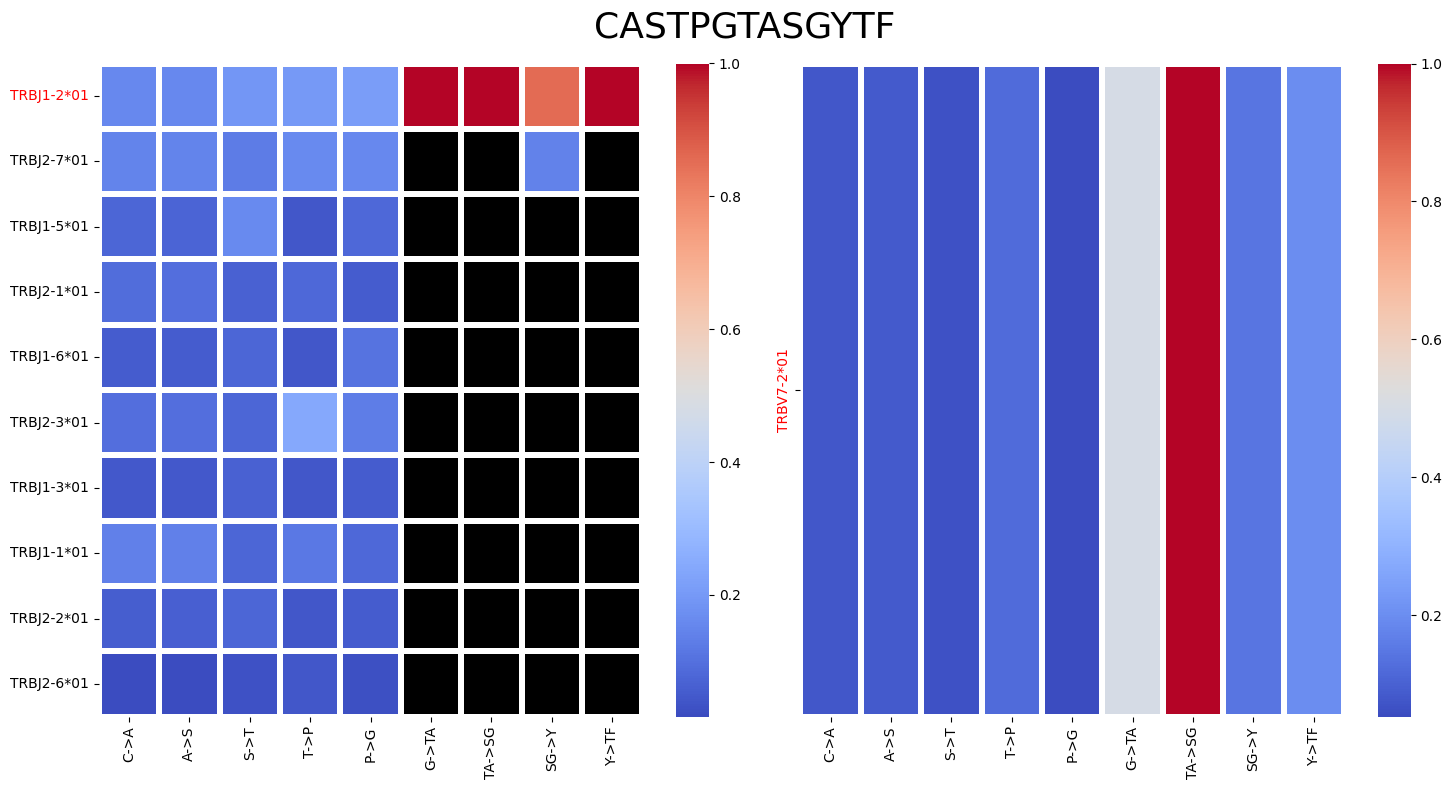

(<Figure size 1500x800 with 4 Axes>, (<Axes: >, <Axes: >))

In [24]:
from LZGraphs import plot_gene_edge_variability
sequence = 'CASTPGTASGYTF'
plot_gene_edge_variability(my_aap_lzgraph,sequence)

### 6. Graph Summary

You can get a quick overview of your graph's statistics using the `graph_summary` method:

In [25]:
my_aap_lzgraph.graph_summary()

Chromatic Number         6
Number of Isolates       0
Max In Deg              81
Max Out Deg            109
Number of Edges       9528
dtype: int64

### 7. Saving and Loading Graphs

LZGraphs can be saved to disk and loaded later. This is useful for:
- Avoiding recomputation for large repertoires
- Sharing graphs between analysis sessions
- Creating reproducible analysis pipelines

#### Saving a Graph

In [26]:
# Save to pickle format (fastest, preserves all data)
my_aap_lzgraph.save('my_graph.pkl')

# Save to JSON format (human-readable, good for sharing)
my_aap_lzgraph.save('my_graph.json', format='json')

# Save with compression
my_aap_lzgraph.save('my_graph.pkl.gz')

print("Graph saved successfully!")

Graph saved successfully!


#### Loading a Graph

In [27]:
# Load from file (format is auto-detected)
loaded_graph = AAPLZGraph.load('my_graph.pkl')

# Verify it's the same graph
print(f"Original nodes: {len(my_aap_lzgraph.nodes)}")
print(f"Loaded nodes: {len(loaded_graph.nodes)}")
print(f"Graphs are equal: {my_aap_lzgraph == loaded_graph}")

Original nodes: 1692
Loaded nodes: 1692
Graphs are equal: True


### 8. Information-Theoretic Metrics

LZGraphs provides entropy-based measures for quantifying the diversity and information content of repertoires:

In [28]:
from LZGraphs import (
    node_entropy,
    edge_entropy, 
    graph_entropy,
    normalized_graph_entropy,
    sequence_perplexity
)

# Calculate entropy metrics
print("=== Entropy Metrics ===")
print(f"Node Entropy: {node_entropy(my_aap_lzgraph):.2f} bits")
print(f"Edge Entropy: {edge_entropy(my_aap_lzgraph):.2f} bits")
print(f"Graph Entropy: {graph_entropy(my_aap_lzgraph):.2f} bits")
print(f"Normalized Entropy: {normalized_graph_entropy(my_aap_lzgraph):.3f} (0-1 scale)")

=== Entropy Metrics ===
Node Entropy: 7.46 bits
Edge Entropy: 2.69 bits
Graph Entropy: 10.15 bits
Normalized Entropy: 0.424 (0-1 scale)


#### Sequence Perplexity

Perplexity measures how "surprised" the model is by a sequence. Lower perplexity indicates the sequence fits well within the repertoire:

In [29]:
# Calculate perplexity for a sequence from our repertoire
test_sequence = example_sequences['cdr3_amino_acid'].iloc[0]
ppl = sequence_perplexity(my_aap_lzgraph, test_sequence)
print(f"Sequence: {test_sequence}")
print(f"Perplexity: {ppl:.2f}")

Sequence: CASSGLAGSRSYNEQFF
Perplexity: 5.25


### 9. Comparing Two Repertoires

You can compare two repertoires by measuring the divergence between their graphs:

In [30]:
from LZGraphs import jensen_shannon_divergence

# Split data to create two different repertoires
repertoire_1 = example_sequences.iloc[:2500]
repertoire_2 = example_sequences.iloc[2500:]

# Build graphs for each
graph_1 = AAPLZGraph(repertoire_1, verbose=False)
graph_2 = AAPLZGraph(repertoire_2, verbose=False)

# Calculate Jensen-Shannon divergence (symmetric, bounded 0-1)
js_div = jensen_shannon_divergence(graph_1, graph_2)
print(f"Jensen-Shannon Divergence: {js_div:.4f}")
print("(0 = identical, 1 = completely different)")

Jensen-Shannon Divergence: 0.0277
(0 = identical, 1 = completely different)


### 10. Error Handling

LZGraphs provides specific exception classes to help you handle errors gracefully:

In [31]:
from LZGraphs import (
    EmptyDataError,
    MissingColumnError,
    InvalidSequenceError,
    NoGeneDataError
)

# Example: Handling missing column error
try:
    bad_data = pd.DataFrame({'wrong_column': ['CASSAF']})
    graph = AAPLZGraph(bad_data, verbose=False)
except MissingColumnError as e:
    print(f"Caught MissingColumnError: {e}")

# Example: Handling empty data
try:
    empty_data = pd.DataFrame(columns=['cdr3_amino_acid'])
    graph = AAPLZGraph(empty_data, verbose=False)
except EmptyDataError as e:
    print(f"Caught EmptyDataError: {e}")

Caught MissingColumnError: Required column 'cdr3_amino_acid' not found in DataFrame. Available columns: ['wrong_column']
Caught EmptyDataError: DataFrame is empty. Cannot build LZGraph from zero sequences.


### Cleanup

Remove temporary files created during this tutorial:

In [32]:
import os

# Clean up saved files
for f in ['my_graph.pkl', 'my_graph.json', 'my_graph.pkl.gz']:
    if os.path.exists(f):
        os.remove(f)
        print(f"Removed {f}")

Removed my_graph.pkl
Removed my_graph.json
Removed my_graph.pkl.gz
